## K-Nearest Neighbors(KNN)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# User defined functions

In [ ]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

## Exploratory Data Analysis and Visualization

In [ ]:
df = pd.read_csv('gene_expression.csv')
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df["Cancer Present"].value_counts()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x='Gene One',y='Gene Two',c='Cancer Present', data=df, cmap="coolwarm")
axin = ax.inset_axes([1.1, -0.1, 0.4, 0.4])
axin.scatter(x='Gene One',y='Gene Two',c='Cancer Present', data=df, cmap="Paired")
axin.set_xlim(3.5, 6)
axin.set_ylim(5.5, 8)
ax.indicate_inset_zoom(axin, linewidth=2, color="black");
axin1 = ax.inset_axes([1.1, 0.7, 0.4, 0.4])
axin1.scatter(x='Gene One',y='Gene Two',c='Cancer Present', data=df, cmap="Paired")
axin1.set_xlim(6, 8)
axin1.set_ylim(3, 5.5)
ax.indicate_inset_zoom(axin1, linewidth=2, color="black");


# KNN algorithms give much better results on data that are seperated from each other.
# On the other hand, it gives bad results with complicated data
# For example, this data will make the most mistakes in border-boundary observations,
# that is, in places that are intricately connected to each other.

In [ ]:
sns.pairplot(data=df, hue="Cancer Present", height=4, aspect =1);

# Gene one feature, the 2 classes seem to be intricately related to each other by almost 50%.
# Gene two feature, the 2 class seem to be intricately related to each other by almost %25.
# Gene two feature is more succesful seperating classes.

# Lets check these insights with Boxplot

In [ ]:
sns.boxplot(x= 'Cancer Present', y = 'Gene One', data=df);

# The bigger gene one gets, the greater the risk of getting cancer.
# In Gene one 2 classes overlap more compared to Gene two.

In [ ]:
sns.boxplot(x= 'Cancer Present', y = 'Gene Two', data=df);

# The smaller gene two gets, the greater the risk of getting cancer.

In [ ]:
sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True, cmap="coolwarm");

# We can see similar insights as we extracted from the boxplots.

## Train|Test Split and Scaling Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modelling

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Taking basic scores with Dummy_classifier
- DummyClassifier makes predictions that ignore the input features.

- This classifier serves as a simple baseline to compare against other more
complex classifiers.


In [ ]:
DummyClassifier?

In [ ]:
operations = [("scaler", StandardScaler()), ("dummy", DummyClassifier(strategy="stratified", random_state=42))]

dummy_model = Pipeline(steps=operations)

dummy_model.fit(X_train, y_train)


In [ ]:
eval_metric(dummy_model, X_train, y_train, X_test, y_test)

In [ ]:
# Now we exemined our basic score for hold out test set and we need to improve accuracy of it.

### KNN

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

# Since KNN is distance-based algortihm we must scale the data
# Each classes takes values in between 1-10. We can pass the scaling but it is better to try either way.

In [ ]:
y_pred = pipe_model.predict(X_test)
y_pred

In [ ]:
y_pred_proba = pipe_model.predict_proba(X_test)

# If weights=uniform then all neighbors are equally weighted. If weights=distance closer neighbors get more weight
# farther neighbors are less weighted.

# According to neighbor count and weights hyperparameters classes are determined.

In [ ]:
pd.DataFrame(y_pred_proba)

# weights= uniform and k=5 so 3 out of 5 neighbors around 895th sample belongs to class 1 (0.6)
# 2 out of 5 neighbors around 895th sample belongs to class 0 (0.4). Since it is assigned to class 1

In [ ]:
my_dict = {"Actual": y_test, "Pred":y_pred, "Proba_1":y_pred_proba[:,1], "Proba_0":y_pred_proba[:,0]}

In [ ]:
pd.DataFrame.from_dict(my_dict).sample(10)

# Real class label, predicted class, probability to belong class 1 and  probability to belong class 0 together.

## Model Performance on Classification Tasks

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_model,X_test, y_test)

In [ ]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

## Elbow Method for Choosing Reasonable K Values

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
test_error_rates = []


for k in range(1,30):

    operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]

    knn_pipe_model = Pipeline(steps=operations)

    scores = cross_validate(knn_pipe_model, X_train, y_train, scoring = ['accuracy'], cv = 10)

    accuracy_mean = scores["test_accuracy"].mean()

    test_error = 1 - accuracy_mean

    test_error_rates.append(test_error)

# To find Optimal K value if data is blanced use accuracy metric if imbalanced use recall of target class

# For each k between 1-30 first find accuracy score than substract this acuuracy score from 1 to find error score(1-acc)

# Since optimal K value found using test data (hold out set) can cause data leakage problem
# while using train data in CV and we evaluate our model over validation set error score.

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.074, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.069, xmin = 0, xmax = 30, colors= 'r', linestyles="--");

# We visualize the error scores we find.

## Overfiting and underfiting control for k values

In [ ]:
test_error_rates = []
train_error_rates = []


for k in range(1,30):

    operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]

    knn_pipe_model = Pipeline(steps=operations)

    knn_pipe_model.fit(X_train,y_train)

    scores = cross_validate(knn_pipe_model, X_train, y_train, scoring = ['accuracy'], cv = 10, return_train_score=True)

    accuracy_test_mean = scores["test_accuracy"].mean()
    accuracy_train_mean = scores["train_accuracy"].mean()


    test_error = 1 - accuracy_test_mean
    train_error = 1 - accuracy_train_mean
    test_error_rates.append(test_error)
    train_error_rates.append(train_error)

# Like the same process as above.We compare the average error errors of the validation and train data
# we have obtained from the train data given in the CV
# Thus, we will be able to see more easily whether it has overfitting or not.

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)

plt.plot(range(1,30), train_error_rates, color='green', linestyle='--', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.074, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.069, xmin = 0, xmax = 30, colors= 'r', linestyles="--");

# The reds are the validation data, the blues are the scores of the train data.
# The lowest error score for the validation data was achieved at K=21,
# but if we choose 21, the complexity of the model, that is, the operation costs, MIGHT increase.
# While the error is 0.074 for K= 9, the error is 0.069 for K=21. For a difference of 0.005,
# is it worth risking the chance of increasing computational complexity?
# It's not worth the expense for a difference of 0.005.

# Keep in mind that the computational complexity of KNN wif the search algorithm is brute force is generally O(nd).
# This means, the value of k won't affect the computational complexity of the problem significantly.
# However, if the search algorithm is a tree based algorithm (kd-tree or ball-tree),
# then the value of k actually will impact the computational complexity of the model.

# At K=21, the scores are almost the same as the error scores in both validation and train data.
# However, if K=9, the error score of the validation data is 0.074, while the error score of the train data is 0.060.
# The difference is 0.014. In other words, since the difference is very small, we can choose K=9 with peace of mind.

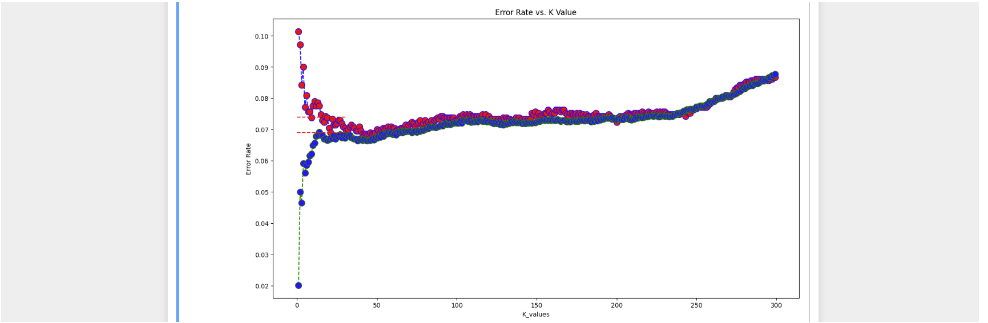

## Scores by Various K Values

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=1))]
knn1 = Pipeline(steps=operations)

knn1.fit(X_train, y_train)
print('WITH K=1\n')
eval_metric(knn1, X_train, y_train, X_test, y_test)


In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=21))]
knn21 = Pipeline(steps=operations)

knn21.fit(X_train, y_train)
print('WITH K=21\n')
eval_metric(knn21, X_train, y_train, X_test, y_test) #28+21 wrong prediction

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=9))]
knn9 = Pipeline(steps=operations)

knn9.fit(X_train, y_train)
print('WITH K=9\n')
eval_metric(knn9, X_train, y_train, X_test, y_test) # 28 + 24 wrong prediction

## Cross Validate For Optimal K Value

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=9))]
model = Pipeline(steps=operations)

scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=['accuracy',
                                 'precision',
                                 'recall',
                                 'f1'],
                        cv=10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

## Gridsearch Method for Choosing Reasonable K Values

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
knn_model = Pipeline(steps=operations)

In [ ]:
knn_model.get_params()

In [ ]:
k_values= range(1,30)

In [ ]:
param_grid = {"knn__n_neighbors":k_values, "knn__p": [1,2], "knn__weights": ['uniform', "distance"]}

# most important hyper_parameters for KNN:
# 1. n_neighbors (In binary classification, it should be noted that k is preferred as odd number
                # so that there can not be equality between the classes.
                # It doesn't matter in multiclass classification the k is odd or even.)
# 2. weights
# 3. p

In [ ]:
knn_grid_model = GridSearchCV(knn_model, param_grid, cv=10, return_train_score=True)

In [ ]:
knn_grid_model.fit(X_train, y_train)

In [ ]:
knn_grid_model.best_estimator_
# GridsearchCV always returns the maximum metric score, which will give the lowest error score.
# Since the number of n_neighbors we will find after GridsearchCV can be very costly,
# it is best practice to choose with the elbow method.

In [ ]:
knn_grid_model.best_index_

In [ ]:
pd.DataFrame(knn_grid_model.cv_results_).loc[knn_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

In [ ]:
print('WITH K=21\n')
eval_metric(knn_grid_model, X_train, y_train, X_test, y_test)

## Evaluating ROC Curves and AUC

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve, RocCurveDisplay, PrecisionRecallDisplay

In [ ]:
RocCurveDisplay.from_estimator(knn9, X_test, y_test)

In [ ]:
y_pred_proba = knn9.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:,1])

In [ ]:
knn9

In [ ]:
PrecisionRecallDisplay.from_estimator(knn9, X_test, y_test);

## Final Model and Model Deployment

In [ ]:
operations = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=9))]

final_model = Pipeline(steps=operations)

final_model.fit(X, y)

In [ ]:
import pickle

In [ ]:
pickle.dump(final_model, open('knn_final_model', 'wb'))

## Predict New Observations

In [ ]:
loaded_model = pickle.load(open('knn_final_model', 'rb'))

In [ ]:
X.describe()

In [ ]:
new_obs = {"Gene One": [1, 3, 4.3, 5.6, 7, 9.5, 2, 6],
           "Gene Two": [1, 4, 4, 5.5, 6.7, 10, 8, 1]
          }

In [ ]:
samples = pd.DataFrame(new_obs)
samples

In [ ]:
predictions = loaded_model.predict(samples)
predictions_proba = loaded_model.predict_proba(samples)

In [ ]:
samples["pred"] = predictions
samples["pred_proba_1"] = predictions_proba[:,1]
samples["pred_proba_0"] = predictions_proba[:,0]
samples